In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 4.4.1 Simulate a MA(2) process and make forecasts 

In [22]:
np.random.seed(42)

ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])

MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

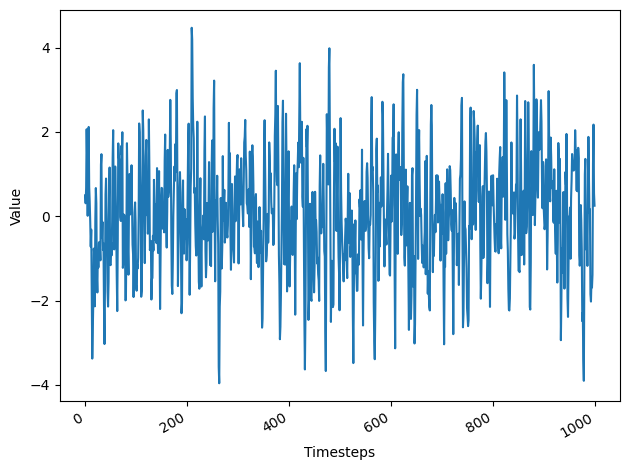

In [23]:
fig, ax = plt.subplots()

ax.plot(MA2_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

In [24]:
ADF_result = adfuller(MA2_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -14.005444309194491
p-value: 3.795601616713556e-26


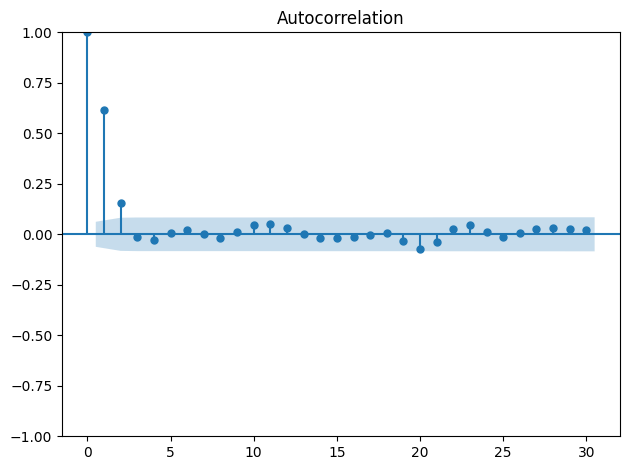

In [25]:
plot_acf(MA2_process, lags=30);

plt.tight_layout()

In [26]:
df = pd.DataFrame({'value': MA2_process})

train = df[:800]
test = df[800:]

In [27]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [28]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA2 = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_MA2'] = pred_MA2

test.head()

,value,pred_mean,pred_last_value,pred_MA2
800,0.973560,-0.017430,0.259693,0.065366
801,0.337338,-0.017430,0.259693,0.017984
802,-0.086834,-0.015752,0.337338,-0.180397
803,-0.530580,-0.015752,0.337338,-0.116820
804,-0.821708,-0.016481,-0.530580,-0.405768


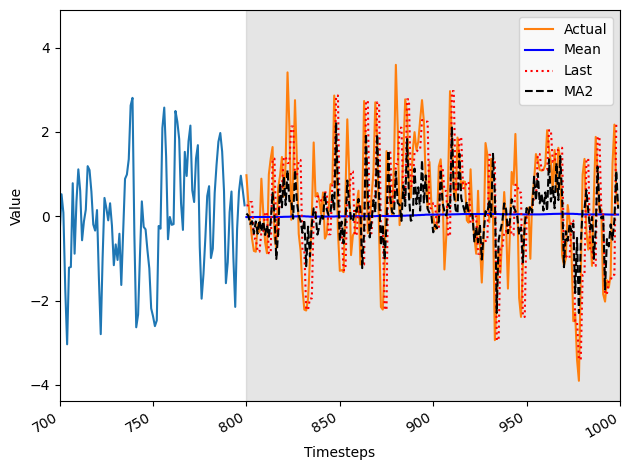

In [29]:
fig, ax = plt.subplots()

ax.plot(train)
ax.plot(test['value'], label='Actual')
ax.plot(test['pred_mean'], 'b-', label='Mean')
ax.plot(test['pred_last_value'], 'r:', label='Last')
ax.plot(test['pred_MA2'], 'k--', label='MA2')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.xlim(700, 1000)
fig.autofmt_xdate()
plt.tight_layout()

In [30]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_MA = mean_squared_error(test['value'], test['pred_MA2'])

print(mse_mean, mse_last, mse_MA)

1.8635013982365882 1.988201688527919 1.2323542190556518


The MA(2) model achieves the lowest MSE, therefore, it is the champion model.

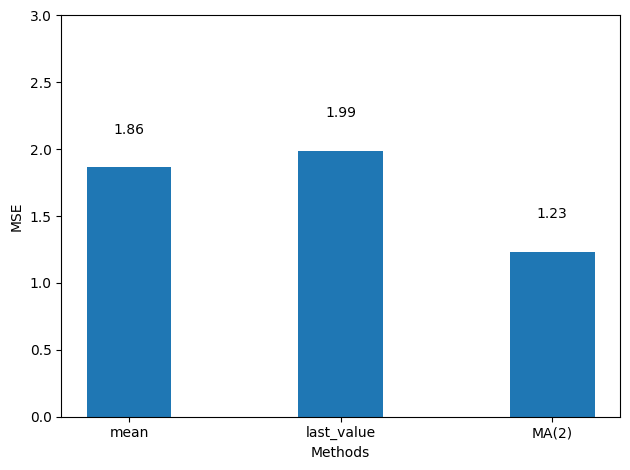

In [31]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 3)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

## Simulate a MA(q) process and make forecasts 

In [32]:
np.random.seed(42)

ma3 = np.array([1, 0.9, 0.3, 0.2])
ar3 = np.array([1, 0, 0, 0])

MA3_process = ArmaProcess(ar3, ma3).generate_sample(nsample=10000)

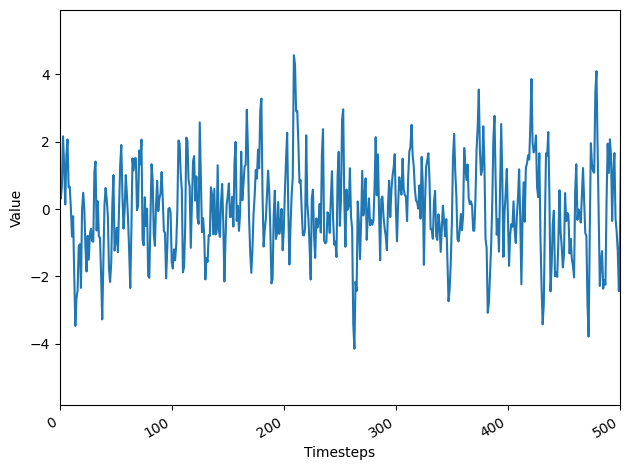

In [33]:
fig, ax = plt.subplots()

ax.plot(MA3_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(0, 500)

fig.autofmt_xdate()
plt.tight_layout()

In [34]:
ADF_result = adfuller(MA3_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -22.871933261080727
p-value: 0.0


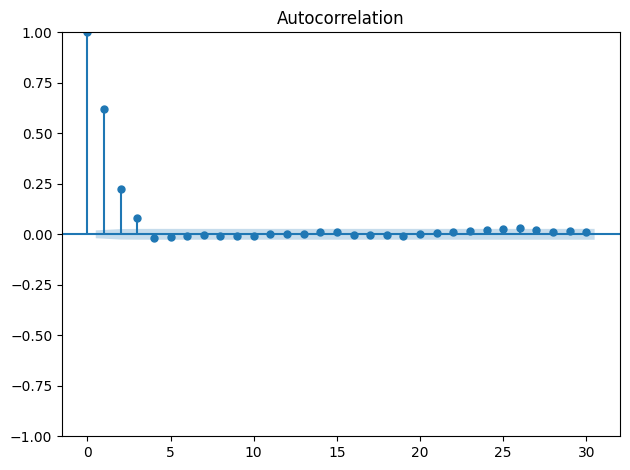

In [35]:
plot_acf(MA3_process, lags=30);

plt.tight_layout()

In [36]:
MA3_df = pd.DataFrame({'value': MA3_process})

MA3_train = MA3_df[:-200]
MA3_test = MA3_df[-200:]

print(len(MA3_test))

200


In [37]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [38]:
TRAIN_LEN = len(MA3_train)
HORIZON = len(MA3_test)
WINDOW = 3

pred_mean = rolling_forecast(MA3_df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(MA3_df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA3 = rolling_forecast(MA3_df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

# The rolling forecast generated 201 predictions, but we need only the first
# 200 predictions to match the length of the test set

MA3_test.loc[:, 'pred_mean'] = pred_mean[:200]
MA3_test.loc[:, 'pred_last_value'] = pred_last_value[:200]
MA3_test.loc[:, 'pred_MA3'] = pred_MA3[:200] 

MA3_test.head()

,value,pred_mean,pred_last_value,pred_MA3
9800,-0.090451,-0.004809,-1.184449,-0.997254
9801,0.965698,-0.004809,-1.184449,-0.344161
9802,2.802072,-0.004809,-1.184449,-0.226325
9803,1.397224,-0.004433,2.802072,2.378104
9804,0.700887,-0.004433,2.802072,0.733305


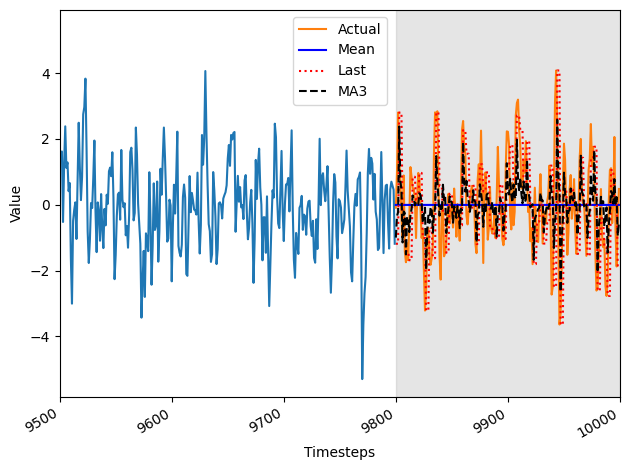

In [39]:
fig, ax = plt.subplots()

ax.plot(MA3_train)
ax.plot(MA3_test['value'], label='Actual')
ax.plot(MA3_test['pred_mean'], 'b-', label='Mean')
ax.plot(MA3_test['pred_last_value'], 'r:', label='Last')
ax.plot(MA3_test['pred_MA3'], 'k--', label='MA3')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(9800, 10000, color='#808080', alpha=0.2)

plt.xlim(9500, 10000)
fig.autofmt_xdate()
plt.tight_layout()

In [40]:
mse_mean = mean_squared_error(MA3_test['value'], MA3_test['pred_mean'])
mse_last = mean_squared_error(MA3_test['value'], MA3_test['pred_last_value'])
mse_MA = mean_squared_error(MA3_test['value'], MA3_test['pred_MA3'])

print(mse_mean, mse_last, mse_MA)

1.9248140859815992 3.1865529484710264 1.5065280391188816


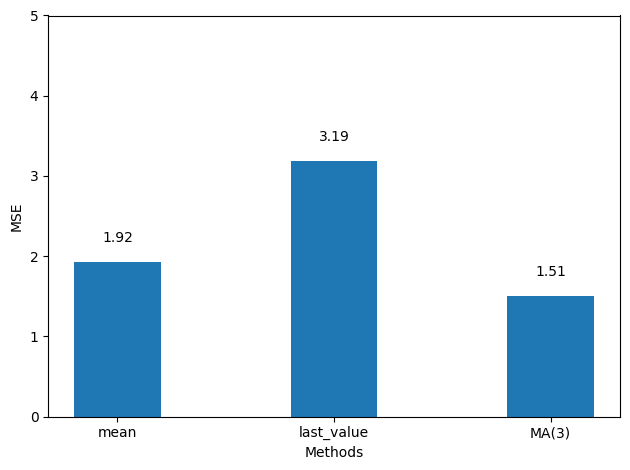

In [41]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(3)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [50]:
np.concatenate((np.array([np.NaN]), np.diff(original_all)))

array([nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [51]:
# Provjera logike za de-diferenciranje
import pandas as pd
import numpy as np

original_all = [20, 21, 22, 23, 24, 25, 26, 27, 28]
diffs_pred = np.diff(original_all)[-6:]


original = pd.DataFrame({"Value" : original_all,
                         "first_diff": np.concatenate((np.array([np.NaN]), np.diff(original_all)))
                         })
print(np.cumsum(diffs_pred))

forecast_len = len(diffs_pred)
original.loc[:, "de_diff"] = pd.Series()

original.loc[3:, "de_diff"] = original["Value"].iloc[2] + np.cumsum(diffs_pred)
original

[1 2 3 4 5 6]


,Value,first_diff,de_diff
0,20,NaN,NaN
1,21,1.0,NaN
2,22,1.0,NaN
3,23,1.0,23
4,24,1.0,24
5,25,1.0,25
6,26,1.0,26
7,27,1.0,27
8,28,1.0,28


In [26]:
def diff_inv(series_diff, first_value):
    series_inverted = np.r_[first_value, series_diff].cumsum().astype('float64')
    return series_inverted

In [27]:
diff_inv(diffs_pred, original["Value"].iloc[2])

array([22., 23., 24., 25., 26., 27., 28.])

In [53]:
diff_inv(original["first_diff"][1:], original["Value"].iloc[0])

array([20., 21., 22., 23., 24., 25., 26., 27., 28.])

In [55]:
original["Value"].iloc[0] + np.cumsum(original["first_diff"][1:])

# Df [1:] je početna iloc[1 minus jedan]

1    21.0
2    22.0
3    23.0
4    24.0
5    25.0
6    26.0
7    27.0
8    28.0
Name: first_diff, dtype: float64